In [1]:
# If you want interactive plots
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

# Delay of AP
This notebook focuses on modeling the delay of an AP under a sinusoid stimulus. 

The idea is to be able to modulate the signal (amplitude, frequency and duration) to change the moment in which an AP is triggered. In a simpler scenario, a pulse that triggers an AP could simply be delayed in time but this is not covered (and would most likely dominate the solution space as the propagation speed is constant)

## Examples
The following examples are covered:
- Parameter space exploration using Predictive Variance.
- Target delay optimzation using ExptectedImprovement/AugementedExpectedImprovement.
- Target delay optimization under constraints using a combined acquisition of (Augemented) ExpectedImprovement + ExpectedFeasibility.

## Advanced examples
We extend the analysis by introducing Gaussian Noise in the readouts and Greedy exploration.
- The first scenarios (Noise) evaluate the robustness and convergence.
- The second scenarios focus on exploring and then optimizing the best known solution.


In [2]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import tensorflow as tf
import pandas as pd
from scipy.optimize import minimize

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro import online_learning 
from online_neuro.utils import CustomMinMaxScaler, CustomBox

from trieste.data import Dataset
from trieste.acquisition.function.active_learning import PredictiveVariance, ExpectedFeasibility
from trieste.acquisition.function.function import AugmentedExpectedImprovement
from trieste.acquisition.combination import Product
from trieste.acquisition.interface import SingleModelAcquisitionBuilder

from trieste.acquisition.rule import EfficientGlobalOptimization

from cajal.nrn import Backend as N
from cajal.nrn import SimulationEnvironment
from cajal.nrn.cells import MRG
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn.sources import IsotropicPoint
from cajal.units import mm, um, ms, ohm, cm

from simulators.python.problems.cajal_problems import create_mrg
from simulators.python.processing.cajal_processing import get_ap_directional, calculate_delay
from simulators.python.pulses import IncreasingSine, IncreasingCosine
from common.plotting_cajal import plot_setup_3d, plot_first_detection

2025-10-31 17:58:09.647877: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 17:58:09.686924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-31 17:58:09.686951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-31 17:58:09.687788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-31 17:58:09.693163: I tensorflow/core/platform/cpu_feature_guar

numprocs=1


# 1. Experiment Setup

# 1.1 Sinusoid ramp waveforms
The sinusoid ramp waveforms increase in magnitude until amp is achieved (and if duration is sufficient).
The parameters could be conditioned to guarantee that a full pulse is injected (i.e. conditioning frequency of duration, not done here)

Text(0.5, 0.98, 'Increasing sinusoid')

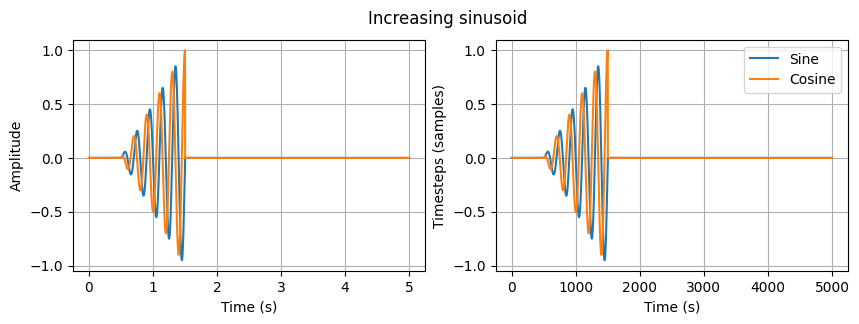

In [4]:
t = np.arange(5000)/1000
sin_wave = IncreasingSine(amp=1, freq=5, duration=1, delay=0.5)
cos_wave = IncreasingCosine(amp=1, freq=5, duration=1, delay=0.5)

fig, ax = plt.subplots( figsize=(10, 3), ncols=2)
ax[0].plot(t, sin_wave(t),label='Sine')
ax[0].plot(t, cos_wave(t),label='Cosine')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].grid()
ax[1].plot(sin_wave(t),label='Sine')
ax[1].plot(cos_wave(t),label='Cosine')
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Timesteps (samples)")
ax[1].grid()
ax[1].legend()
fig.suptitle("Increasing sinusoid")

## 1.1 Single electrode setup


In [5]:
# Time resolution
N.dt = 0.005*ms

AXON_DIAMETER = 27*um # um
# AXON_NODES = 150 # number of axon nodes
AXON_LENGTH = 120
STIM_DISTANCE = -20
MEAS_DISTANCE = 30

In [6]:
mrg = create_mrg(diameter=AXON_DIAMETER,
                 length=AXON_LENGTH,
                 v_init=-80, 
                 #axonnodes=AXON_NODES, 
                 verbose=True)

# Estimate the closest node to desired measurement distance
mid_point = int(mrg.axonnodes/2)
distance_per_node = AXON_LENGTH/mrg.axonnodes
displacement_nodes = int(MEAS_DISTANCE/distance_per_node)
MEAS_POSITION = mid_point + displacement_nodes 
print(f"Stimulation distance: {STIM_DISTANCE}")
print(f"Measuring distance: {MEAS_DISTANCE} at node # {MEAS_POSITION}")

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm
Stimulation distance: -20
Measuring distance: 30 at node # 153


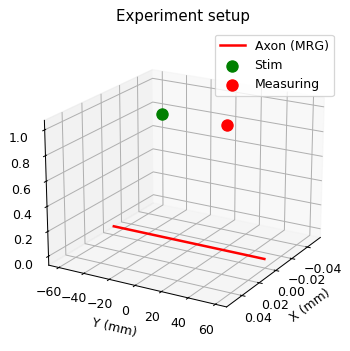

In [7]:
# extracellular current source
pointsource = IsotropicPoint(x=0, y = STIM_DISTANCE * mm, z= 1 * mm, rhoe= 500*ohm*cm)
stim_amp = -1
stim_freq = 5
stim_duration = 2 
stim_delay = 0.25
stim = IncreasingSine(amp=stim_amp, 
                      freq=stim_freq,
                      duration=stim_duration,
                      delay=stim_delay)

electrode = pointsource << stim # Assignment

measuring_ps = IsotropicPoint(x=0, y = MEAS_DISTANCE * mm, z= 1 * mm, rhoe= 500*ohm*cm)
v_rec = StateMonitor(mrg.node, "v")

plot_setup_3d(mrg, [pointsource, measuring_ps], ['Stim','Measuring'],
              figsize=(4,4), title='Experiment setup',dpi=90)

In [8]:
# simulation environment
env = SimulationEnvironment(axons=[mrg], extra_stim=[electrode],
                            monitors=[v_rec])
env.run(runtime = 4 * ms,  progressbar=True, early_stopping=False)


3.5 ms: 100%|██████████| 800/800 [00:01<00:00, 531.29it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 1
  dt: 0.005 ms

## 1.2 Visualizing the nerve conduction overt time and space

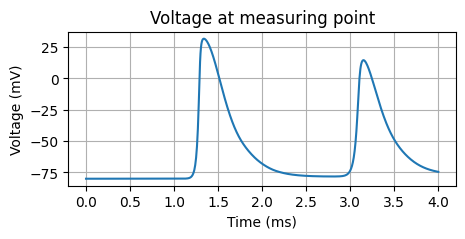

In [9]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(v_rec.t, v_rec.v[MEAS_POSITION,:])
ax.set_title("Voltage at measuring point")
ax.set_ylabel("Voltage (mV)")
ax.set_xlabel("Time (ms)")
ax.grid()

Delay: 1.03 ms
{'delay': 1.0349999999999837, 'num_aps': 2}


<Axes: title={'center': 'AP propagation'}, xlabel='Time (ms)', ylabel='Node Number'>

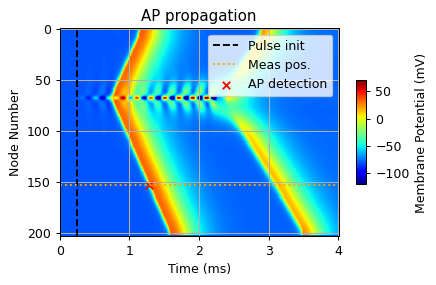

In [10]:
# An example of a failed blocking the AP progression to the right
res = calculate_delay(stim_time = stim_delay , v_rec= v_rec, node= MEAS_POSITION)
print(f"Delay: {res['delay']:.2f} ms")
print(res)
plot_first_detection(mrg=mrg,
                     v_rec=v_rec,
                     stim_delay=stim_delay,
                     meas_position=MEAS_POSITION,
                     propagation_delay=res['delay'],
                     figsize=(5,3),
                     dpi=90,
                     title="AP propagation")


## 1.4 Experiment and Objective definition

In [11]:
def run_simulation(mrg: MRG, 
                   
                   stim_amp: float = -1.00, #* mA
                   stim_freq: float = 1.0, #kHz
                   stim_pw: float = 0.50, #* ms
                   stim_delay: float = 2.0, #* ms
                   
                   e_pos: float = 20.0, # mm
                   z_pos: float = 1.0, # mm
                   
                   sim_time: float = 5.0, # ms
                   verbose: bool = True) -> dict[str, APMonitor|StateMonitor]:
    """
    Run the simulation with given stimulus parameters.
    
    Parameters:
    - mrg: Instance of MRG model
    
    - stim_amp: Amplitude of the stimulus pulse (mA)
    - stim_pw: Pulse width of the simtulus pulse (ms)
    - stim_delay: Delay of the stimulus pulse (ms)
    
    General assumptions:
    - Electrodes are placed along the axon (y axis by default).
    - X placement is centered at 0 mm (origin).
    - Z placement is the same for both electrodes.
    
    - Medium is isotropic with a fixed resistivity of 500 ohm*cm.
    
    Returns:
    - monitor_dict: Dictionary containing the simulation results (StateMonitor)
    """

    if verbose:
        print(f"Config: Amp. {stim_amp:.2f} mA Freq. {stim_freq:.2f} KHz,  PW {stim_pw:.2f} ms, Delay {stim_delay:.2f} ms")

    # Create stimuli
    stim = IncreasingSine(amp=stim_amp,
                          freq=stim_freq,
                          duration=stim_duration,
                          delay=stim_delay)

    # Create electrodes at both ends (set spacing of electrode_separation mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=e_pos * mm, z=z_pos * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    
    monitors_dict = dict()
    v_rec = StateMonitor(mrg.node, "v")
    
    monitors_dict['v_rec'] = v_rec
    # Create the simulation environment
    env = SimulationEnvironment(
        axons = [mrg],
        extra_stim = [electrode_stim],
        monitors = [v_rec]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(sim_time * ms, early_stopping=False)
    
    return monitors_dict


In [ ]:
def sinusoid_delay_objective(mrg: MRG,
                             meas_position: int,
                             stim_amp: list[float] = [-1], 
                             stim_pw: list[float] = [0.5],
                             stim_delay: list[float] = [2],
                             stim_freq: list[float] = [1],
                             abs_diff: bool = False,
                             plot_results: bool = False,
                             noise_level: float = 0.0,
                             verbose: bool = True,
                             *args,
                             **kwargs
                             ) -> list[dict]:
    """
    Objective function to optimize AP blocking
    """  
              
    observations = []
    default_dict = {
        'ap_lines': [],
        'arrival_delay': np.nan
    }
    
    for s_amp, s_pw, s_delay, s_freq in zip(stim_amp, stim_pw, stim_delay, stim_freq):
        # Run the simulation with given parameters
        try:
            monitors_dict = run_simulation(mrg = mrg,
                                           stim_amp = s_amp,
                                           stim_pw = s_pw,
                                           stim_delay = s_delay,
                                           stim_freq = s_freq,
                                           *args,
                                           **kwargs)
            
            v_rec = monitors_dict['v_rec']            
            v_binary = v_rec.v > -0.20 # Assuming some threshold
            
            ap_lines = get_ap_directional(v_binary, 
                                          min_nodes_for_ap_start=1,
                                          y_propagation_threshold=5)
            
            results = calculate_delay(stim_time = s_delay, 
                                      v_rec = v_rec, 
                                      node = meas_position,
                                      abs_diff = abs_diff)
            if noise_level>0.0:
                results['delay_noised'] = results['delay'] + np.random.normal(0, noise_level)

            results['ap_lines'] = ap_lines
            
            if plot_results:
                plot_first_detection(mrg=mrg,
                                    v_rec=v_rec,
                                    stim_delay=s_delay,
                                    meas_position=meas_position,
                                    propagation_delay=results['delay'],
                                    figsize=(5,3),
                                    dpi=90,
                                    title="AP propagation")
                plt.show()
            if verbose: 
                print(results)
            
            observations.append(results)

        except Exception:
            print(f"Simulation failed with Amplitude {stim_amp:.2f} mA, Frequency {stim_freq:.2f} Hz,  Pulse Width {stim_pw:.2f} ms, Delay {stim_delay:.2f}")
            observations.append(default_dict)  

    return observations 

# 2 Optimization


## 2.1 Performing Gaussian Process based Bayesian Optimization

In [13]:
# Define parameter (bounds) for the blocking AP
# stim_amp = 0 - 2 mA
# stim_freq = 5 # kHz
# stim_duration = 0.2 - 3 ms
# stim_delay = 0.5 is kept constant

lb = [0, 2.0, 0.2]  # Lower bounds for [block_amp, freq, pulse_width]
ub = [2, 10.0, 3]  # Upper bounds
col_names = ['Amplitude (mA)', 'Freq (kHz)', 'Pulse width (ms)']

STIM_DELAY = 0.5 # Delay initial pulse in ms
NOISE_LEVEL = 0.2/2 # Gaussian distributed noise in ms (90% of the time within this error) 
#NOISE_LEVEL = 0

abs_diff = False # Here we model the delays therefore we don't use the absolute difference (symetric)

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, 
                            feature_max=ub,
                            output_range=(-1, 1))

# Define search space
search_space = CustomBox(lower=[-1, -1, -1],
                         upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 10
qp_minmax = search_space.sample_method(init_samples, sampling_method='sobol', skip=0).numpy()
qp_orig_scale = scaler.inverse_transform(qp_minmax)
stim_delay_vector = init_samples*[STIM_DELAY]

# Set desired diameter, length and v_init
mrg = create_mrg(diameter=AXON_DIAMETER,
                 length=AXON_LENGTH, 
                 v_init=-80, 
                 verbose=True)

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


Config: Amp. 1.00 mA Freq. 6.00 KHz,  PW 1.60 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.43it/s]


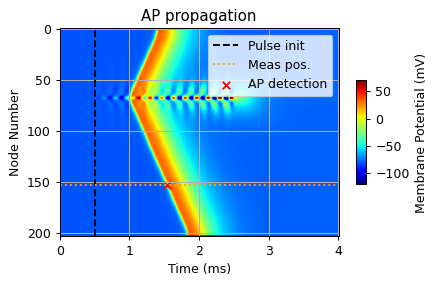

{'delay': 1.0399999999999783, 'num_aps': 1, 'delay_noised': 1.096381423556009, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 205, 'component_end_time': 411, 'upward_line_coords': ((205, 65), (324, 1)), 'downward_line_coords': ((205, 70), (411, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 9, 'component_start_time': 252, 'component_end_time': 266, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 288, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 322, 'component_end_time': 332, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.12it/s]


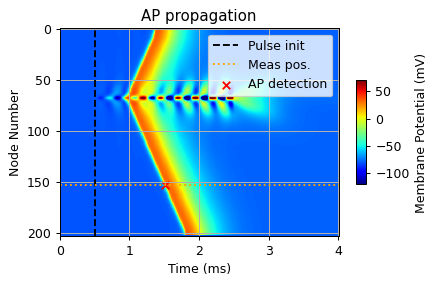

{'delay': 1.004999999999979, 'num_aps': 1, 'delay_noised': 0.9443927911143234, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 188, 'component_end_time': 403, 'upward_line_coords': ((188, 67), (317, 1)), 'downward_line_coords': ((188, 68), (403, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 280, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 331, 'component_end_time': 350, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 8, 'component_start_time': 380, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.09it/s]


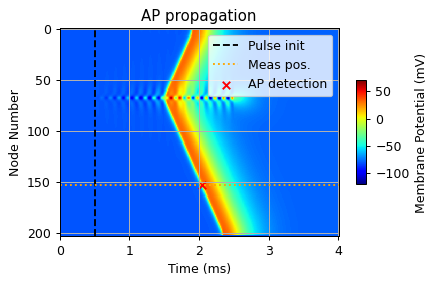

{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.5475130934352999, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 64), (423, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 366, 'component_end_time': 374, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 393, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 418, 'component_end_time': 422, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 210.89it/s]


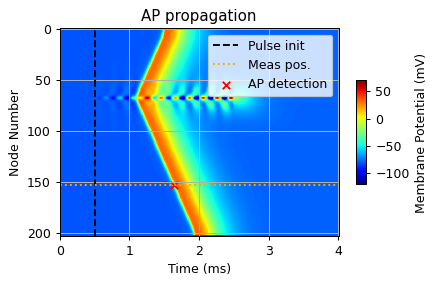

{'delay': 1.1399999999999761, 'num_aps': 1, 'delay_noised': 1.1858515938177179, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 223, 'component_end_time': 430, 'upward_line_coords': ((223, 66), (343, 1)), 'downward_line_coords': ((223, 68), (430, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 7, 'component_start_time': 284, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 7, 'component_start_time': 327, 'component_end_time': 337, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 7, 'component_start_time': 367, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 197.45it/s]


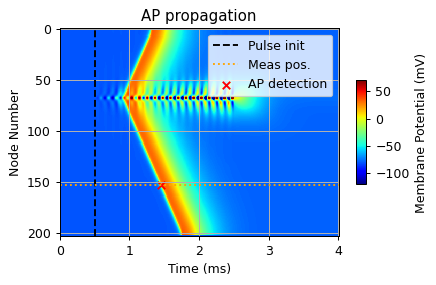

{'delay': 0.9499999999999802, 'num_aps': 1, 'delay_noised': 0.855230572201399, 'ap_lines': [{'label': 1, 'total_of_features': 23, 'component_start_time': 182, 'component_end_time': 392, 'upward_line_coords': ((182, 67), (305, 1)), 'downward_line_coords': ((182, 67), (392, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 7, 'total_of_features': 23, 'component_start_time': 247, 'component_end_time': 255, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 23, 'component_start_time': 270, 'component_end_time': 277, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 9, 'total_of_features': 23, 'component_start_time': 292, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 196.03it/s]


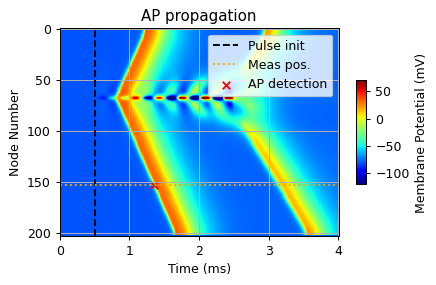

{'delay': 0.8549999999999822, 'num_aps': 2, 'delay_noised': 0.8319946450512009, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 163, 'component_end_time': 373, 'upward_line_coords': ((163, 67), (286, 1)), 'downward_line_coords': ((163, 68), (373, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 275, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 341, 'component_end_time': 366, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 406, 'component_end_time': 433, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 194.51it/s]


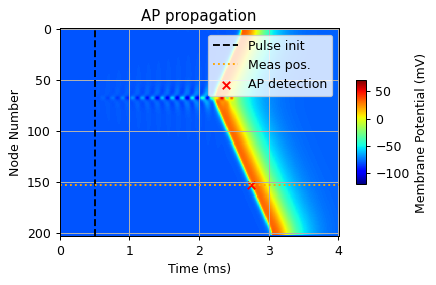

{'delay': 2.2499999999999525, 'num_aps': 1, 'delay_noised': 2.3253007896117026, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 446, 'component_end_time': 652, 'upward_line_coords': ((446, 66), (565, 1)), 'downward_line_coords': ((446, 69), (652, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}]}
Config: Amp. 0.38 mA Freq. 4.50 KHz,  PW 2.83 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 183.78it/s]


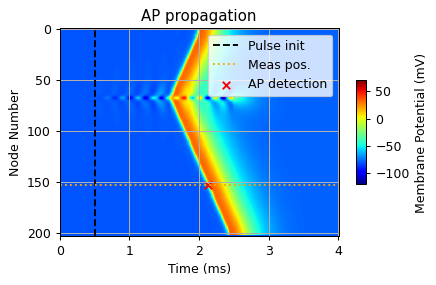

{'delay': 1.6299999999999657, 'num_aps': 1, 'delay_noised': 1.5930157567333683, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 318, 'component_end_time': 529, 'upward_line_coords': ((318, 67), (442, 1)), 'downward_line_coords': ((318, 67), (529, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 397, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 445, 'component_end_time': 449, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 488, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 179.90it/s]


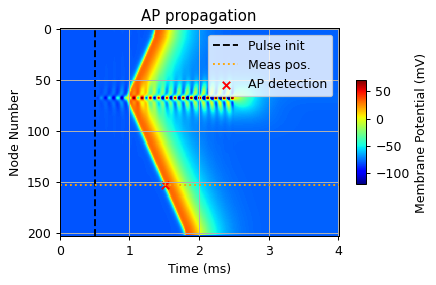

{'delay': 1.004999999999979, 'num_aps': 1, 'delay_noised': 0.9985983323136469, 'ap_lines': [{'label': 1, 'total_of_features': 16, 'component_start_time': 198, 'component_end_time': 403, 'upward_line_coords': ((198, 65), (317, 1)), 'downward_line_coords': ((198, 70), (403, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 4, 'total_of_features': 16, 'component_start_time': 255, 'component_end_time': 264, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 16, 'component_start_time': 280, 'component_end_time': 288, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 16, 'component_start_time': 304, 'component_end_time': 311, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 178.85it/s]


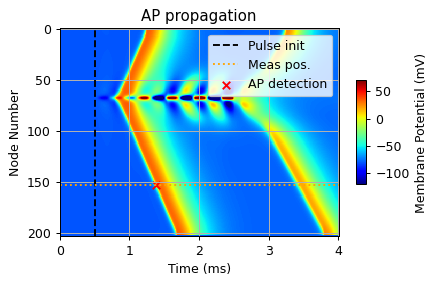

{'delay': 0.8749999999999818, 'num_aps': 2, 'delay_noised': 0.7168681169795736, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 160, 'component_end_time': 378, 'upward_line_coords': ((160, 67), (291, 1)), 'downward_line_coords': ((160, 68), (378, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 13, 'component_start_time': 224, 'component_end_time': 258, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 13, 'component_start_time': 308, 'component_end_time': 340, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 13, 'component_start_time': 356, 'component_end_time': 371, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 61, 'max_y_at_start': 

In [14]:
# Compute observations of for the initial amount of samples
observations = sinusoid_delay_objective(mrg,
                                       
                                       stim_amp = qp_orig_scale[:, 0],
                                       stim_freq = qp_orig_scale[:, 1],
                                       stim_pw = qp_orig_scale[:, 2],
                                       
                                       stim_delay = stim_delay_vector,
                                       meas_position = MEAS_POSITION, 
                                       e_pos=STIM_DISTANCE,
                                       abs_diff = abs_diff,
                                       sim_time = 4,
                                       plot_results = True,
                                       noise_level = NOISE_LEVEL)

## 2.2 Visualizing initial samples

In [15]:
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
real_label = np.array([o['delay'] for o in observations]).reshape(-1,1)

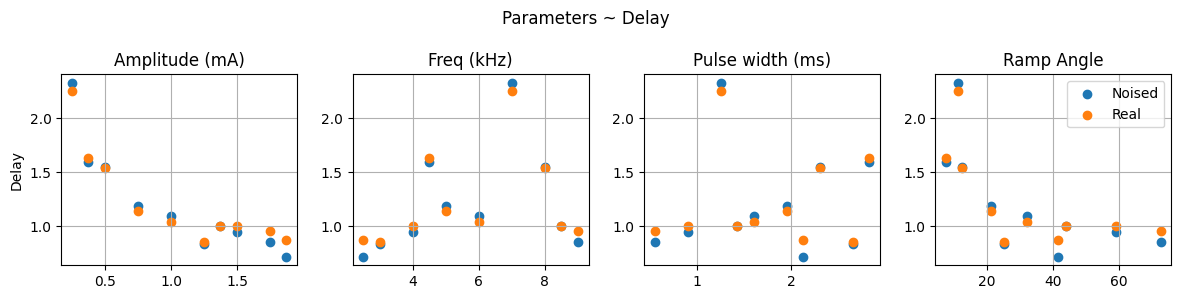

In [16]:

fig, ax = plt.subplots(ncols=4,figsize=(12,3))
ax[0].scatter(qp_orig_scale[:,0], obs_label)
ax[1].scatter(qp_orig_scale[:,1], obs_label)
ax[2].scatter(qp_orig_scale[:,2], obs_label)
ax[3].scatter(np.degrees(np.arctan(qp_orig_scale[:,0]/qp_orig_scale[:,2])), obs_label, label='Noised')

if NOISE_LEVEL>0:
    ax[0].scatter(qp_orig_scale[:,0], real_label)
    ax[1].scatter(qp_orig_scale[:,1], real_label)
    ax[2].scatter(qp_orig_scale[:,2], real_label)
    ax[3].scatter(np.degrees(np.arctan(qp_orig_scale[:,0]/qp_orig_scale[:,2])), real_label, label='Real')


ax[0].set_ylabel("Delay")
for e, col in enumerate(col_names):
    ax[e].set_title(col)
    ax[e].grid()

ax[3].set_title("Ramp Angle")
ax[3].legend()
ax[3].grid()
fig.suptitle("Parameters ~ Delay")
fig.tight_layout()

## 2.3 Meta-models


Here we will approach the model in three different ways:
- As a learning approach focused on reducing Global Uncertainty by means of PredictiveVariance (eventually could be done with IntegratedVarianceReduction).
- As an online optimization problem focused on finding better minimums. In this case, we will defined a target desired delay and model it as an absolute loss so that negative and positive delays are counted the same. We can use ExpectedImprovement or AugmentedExpectedImprovement (a more exploration driven variation)
- We then turn our attention to XsiExpectedImprovement, a variation we use to focus more on exploitation.
- A constrained optimization in which we use ExpectedImprovement and ProbabilityofFeasibility with the intention of targeting a certain delay while avoiding triggering 2 APs.
- Finally, a XsiExpectedImprovement in combination with constraints.

## 2.3.1 Variance Reduction
This model focuses in reducing global variance (exploration) using PredictiveVariance

In [17]:
# If Noise is higher than 0 we assume we are dealing with noisy simulations and select the noised injected sample
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
real_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
# We replace np.inf values with a fixed and relatively large value 
#  (outside of the simulation range)
    
obs_label[obs_label == np.inf] = 6
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))


In [18]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [19]:
# Build model
model_config = {
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'likelihood_variance':1e-5,
    'kernel_variance': None,
}
problem_type = 'regression'
online_model = online_learning.build_model(init_dataset, 
                                           search_space,
                                           model_config,
                                           problem_type=problem_type)

# Set up acquisition function and rule
acq = PredictiveVariance()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell_variance = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [20]:
# Optimization loop as for a next point to query
max_iters = 20  # Increase the number of iterations as needed
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell_variance.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell_variance returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = MEAS_POSITION, 
                                            e_pos = STIM_DISTANCE,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False,
                                            noise_level=NOISE_LEVEL)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
        
    obs_label[obs_label == np.inf] = 6

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell_variance.tell(tagged_output)
    iter += 1

# Save results
#ask_tell_variance.save()

Config: Amp. 0.00 mA Freq. 2.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 174.77it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 2.00 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 160.91it/s]


{'delay': 0.9249999999999807, 'num_aps': 1, 'delay_noised': 1.0862132292301436, 'ap_lines': [{'label': 1, 'total_of_features': 31, 'component_start_time': 176, 'component_end_time': 387, 'upward_line_coords': ((176, 67), (300, 1)), 'downward_line_coords': ((176, 68), (387, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 31, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 'max_y_at_start': 62}, {'label': 31, 'total_of_features': 31, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 72, 'max_y_at_start'

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 166.22it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.93 mA Freq. 10.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 163.42it/s]


{'delay': 1.1799999999999753, 'num_aps': 1, 'delay_noised': 1.2629431386108845, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 233, 'component_end_time': 439, 'upward_line_coords': ((233, 66), (352, 1)), 'downward_line_coords': ((233, 69), (439, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 12, 'component_start_time': 292, 'component_end_time': 300, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 12, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 11, 'total_of_features': 12, 'component_start_time': 334, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 160.15it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 2.00 mA Freq. 6.11 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 149.79it/s]


{'delay': 0.8599999999999821, 'num_aps': 2, 'delay_noised': 0.725462598571401, 'ap_lines': [{'label': 1, 'total_of_features': 23, 'component_start_time': 163, 'component_end_time': 374, 'upward_line_coords': ((163, 67), (287, 1)), 'downward_line_coords': ((163, 68), (374, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 8, 'total_of_features': 23, 'component_start_time': 217, 'component_end_time': 231, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 10, 'total_of_features': 23, 'component_start_time': 251, 'component_end_time': 263, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 11, 'total_of_features': 23, 'component_start_time': 284, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start':

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 182.23it/s]


{'delay': 0.9749999999999797, 'num_aps': 2, 'delay_noised': 0.8375422019646057, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 184, 'component_end_time': 397, 'upward_line_coords': ((184, 67), (311, 1)), 'downward_line_coords': ((184, 67), (397, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 6, 'component_start_time': 261, 'component_end_time': 290, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 363, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 458, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 145.78it/s]


{'delay': 0.9499999999999802, 'num_aps': 1, 'delay_noised': 0.9164790294791696, 'ap_lines': [{'label': 1, 'total_of_features': 23, 'component_start_time': 187, 'component_end_time': 392, 'upward_line_coords': ((187, 64), (305, 1)), 'downward_line_coords': ((187, 71), (392, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 6, 'total_of_features': 23, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 7, 'total_of_features': 23, 'component_start_time': 252, 'component_end_time': 260, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features': 23, 'component_start_time': 273, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 188.26it/s]


{'delay': 1.0699999999999776, 'num_aps': 1, 'delay_noised': 1.091142718535141, 'ap_lines': [{'label': 1, 'total_of_features': 13, 'component_start_time': 212, 'component_end_time': 417, 'upward_line_coords': ((212, 65), (330, 1)), 'downward_line_coords': ((212, 70), (417, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 13, 'component_start_time': 272, 'component_end_time': 280, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 13, 'component_start_time': 293, 'component_end_time': 299, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 13, 'component_start_time': 313, 'component_end_time': 319, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 190.09it/s]


{'delay': 1.054999999999978, 'num_aps': 1, 'delay_noised': 1.0439614208431132, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 207, 'component_end_time': 413, 'upward_line_coords': ((207, 66), (326, 1)), 'downward_line_coords': ((207, 69), (413, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 3, 'component_start_time': 367, 'component_end_time': 393, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 461, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 2.00 mA Freq. 2.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 191.34it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 0.8062466598466097, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 169, 'component_end_time': 390, 'upward_line_coords': ((169, 67), (303, 1)), 'downward_line_coords': ((169, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 256, 'component_end_time': 298, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 6, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 10, 'component_start_time': 412, 'component_end_time': 445, 'upward_line_coords': ((412, 62), (442, 52)), 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 62, 

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 183.23it/s]


{'delay': 0.9399999999999804, 'num_aps': 2, 'delay_noised': 0.9786067307153001, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 171, 'component_end_time': 390, 'upward_line_coords': ((171, 67), (303, 1)), 'downward_line_coords': ((171, 68), (390, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 10, 'component_start_time': 257, 'component_end_time': 297, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 10, 'component_start_time': 415, 'component_end_time': 443, 'upward_line_coords': ((415, 61), (438, 53)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 61, 

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 182.22it/s]


{'delay': 1.3899999999999708, 'num_aps': 1, 'delay_noised': 1.2970448254868603, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 273, 'component_end_time': 480, 'upward_line_coords': ((273, 67), (393, 1)), 'downward_line_coords': ((273, 67), (480, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 10, 'component_start_time': 332, 'component_end_time': 339, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 10, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 374, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 200.56it/s]


{'delay': 1.8399999999999612, 'num_aps': 1, 'delay_noised': 2.0278244112348824, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 366, 'component_end_time': 570, 'upward_line_coords': ((366, 64), (484, 1)), 'downward_line_coords': ((366, 71), (570, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 412, 'component_end_time': 420, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 6, 'component_start_time': 434, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 455, 'component_end_time': 457, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 173.18it/s]


{'delay': 0.9499999999999802, 'num_aps': 2, 'delay_noised': 0.9781358363636118, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 177, 'component_end_time': 393, 'upward_line_coords': ((177, 67), (306, 1)), 'downward_line_coords': ((177, 68), (393, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 259, 'component_end_time': 294, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 360, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 6, 'component_start_time': 457, 'component_end_time': 499, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:05<00:00, 143.79it/s]


{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}
Config: Amp. 0.89 mA Freq. 2.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 176.25it/s]


{'delay': 0.9649999999999799, 'num_aps': 2, 'delay_noised': 0.8791732517057778, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 181, 'component_end_time': 395, 'upward_line_coords': ((181, 67), (308, 1)), 'downward_line_coords': ((181, 68), (395, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 260, 'component_end_time': 291, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 362, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 458, 'component_end_time': 498, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 187.23it/s]


{'delay': 0.9999999999999791, 'num_aps': 2, 'delay_noised': 1.070231055601807, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 192, 'component_end_time': 402, 'upward_line_coords': ((192, 67), (316, 1)), 'downward_line_coords': ((192, 68), (402, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 261, 'component_end_time': 287, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 365, 'component_end_time': 395, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 459, 'component_end_time': 497, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 182.32it/s]


{'delay': 2.039999999999957, 'num_aps': 1, 'delay_noised': 2.076687109768586, 'ap_lines': [{'label': 1, 'total_of_features': 1, 'component_start_time': 403, 'component_end_time': 611, 'upward_line_coords': ((403, 67), (524, 1)), 'downward_line_coords': ((403, 67), (611, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 1.34 mA Freq. 2.00 KHz,  PW 0.20 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 194.79it/s]


{'delay': 0.9449999999999803, 'num_aps': 2, 'delay_noised': 0.9941709167224838, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 174, 'component_end_time': 391, 'upward_line_coords': ((174, 67), (304, 1)), 'downward_line_coords': ((174, 68), (391, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 258, 'component_end_time': 295, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 5, 'total_of_features': 8, 'component_start_time': 359, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 8, 'component_start_time': 421, 'component_end_time': 438, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 60, 'max_y_at_start': 61},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 209.74it/s]


{'delay': 0.9299999999999806, 'num_aps': 1, 'delay_noised': 0.8822157499807816, 'ap_lines': [{'label': 24, 'total_of_features': 32, 'component_start_time': 177, 'component_end_time': 181, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 1, 'total_of_features': 32, 'component_start_time': 182, 'component_end_time': 388, 'upward_line_coords': ((182, 66), (301, 1)), 'downward_line_coords': ((182, 69), (388, 202)), 'y_span_at_start': 2, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 10, 'total_of_features': 32, 'component_start_time': 232, 'component_end_time': 240, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 32, 'component_start_time': 244, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 60, 'max_y_at_start'

In [21]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df_min_variance = pd.DataFrame(all_qp_array, columns=col_names)
df_min_variance['sample_type'] = all_sample_types_array
df_min_variance = pd.concat([df_min_variance, df_all_observations],axis=1)

# Map 'ap_count' to labels
#df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

In [22]:
df_min_variance

,Amplitude (mA),Freq (kHz),Pulse width (ms),sample_type,delay,num_aps,delay_noised,ap_lines
0,1.000000,6.000000,1.600000,Initial,1.040,1,1.096381,"[{'label': 1, 'total_of_features': 9, 'compone..."
1,1.500000,4.000000,0.900000,Initial,1.005,1,0.944393,"[{'label': 1, 'total_of_features': 8, 'compone..."
2,0.500000,8.000000,2.300000,Initial,1.540,1,1.547513,"[{'label': 1, 'total_of_features': 7, 'compone..."
3,0.750000,5.000000,1.950000,Initial,1.140,1,1.185852,"[{'label': 1, 'total_of_features': 7, 'compone..."
4,1.750000,9.000000,0.550000,Initial,0.950,1,0.855231,"[{'label': 1, 'total_of_features': 23, 'compon..."
5,1.250000,3.000000,2.650000,Initial,0.855,2,0.831995,"[{'label': 1, 'total_of_features': 7, 'compone..."
6,0.250000,7.000000,1.250000,Initial,2.250,1,2.325301,"[{'label': 1, 'total_of_features': 1, 'compone..."
7,0.375000,4.500000,2.825000,Initial,1.630,1,1.593016,"[{'label': 1, 'total_of_features': 4, 'compone..."
8,1.375000,8.500000,1.425000,Initial,1.005,1,0.998598,"[{'label': 1, 'total_of_features': 16, 'compon..."
9,1.875000,2.500000,2.125000,Initial,0.875,2,0.716868,"[{'label': 1, 'total_of_features': 13, 'compon..."


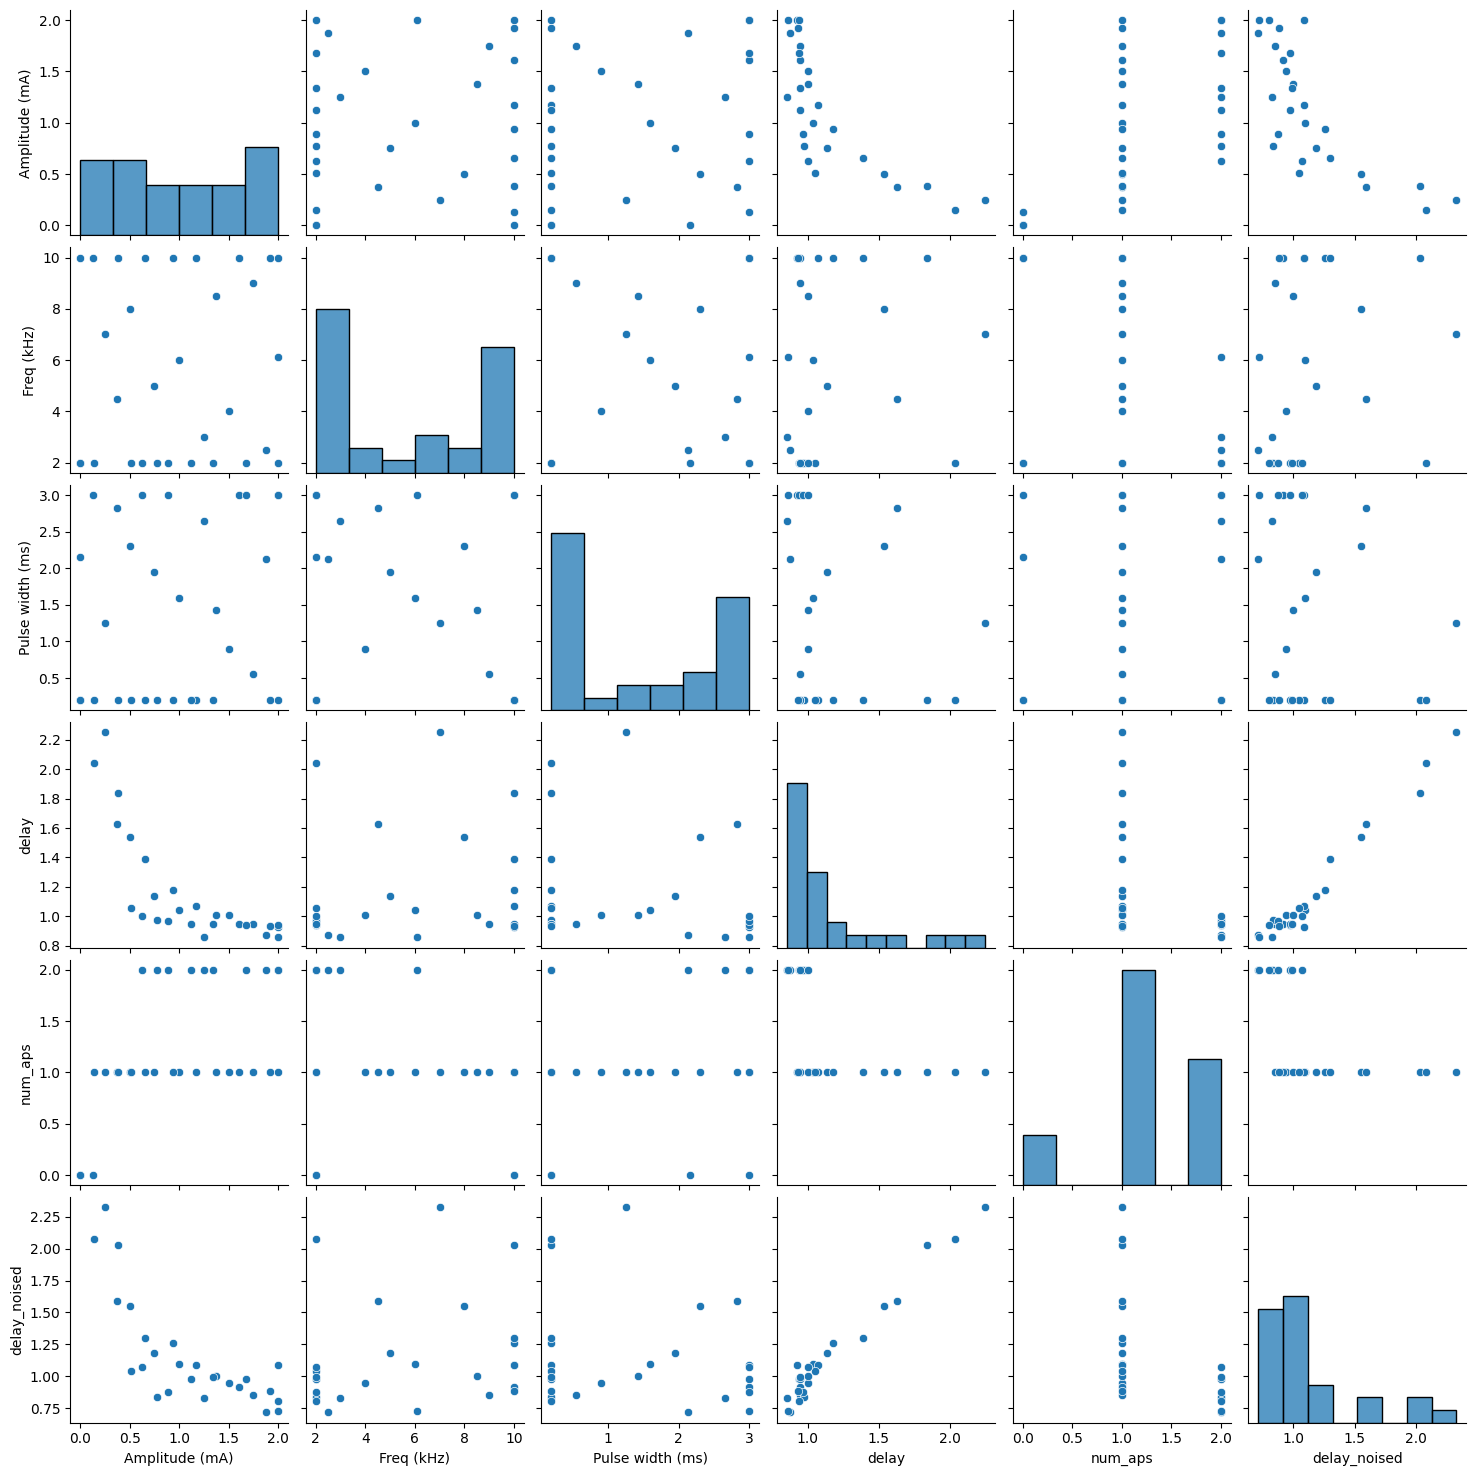

In [23]:
sns.pairplot(df_min_variance)

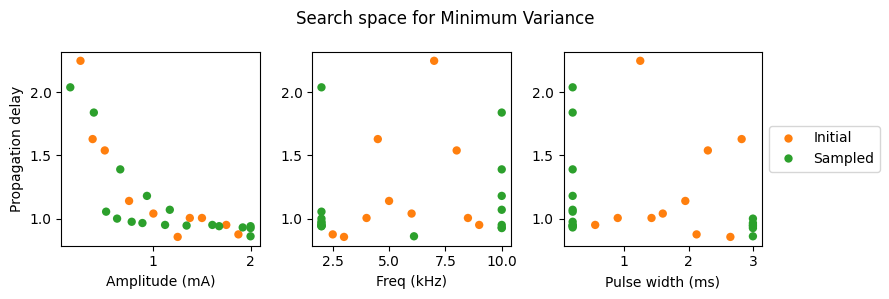

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_variance['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_variance[col], df_min_variance['delay'], c=colors, edgecolors='none')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6)
]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

### 2.3.2 Optimizing for a delay
This model focuses in minimizing an objective function using ExpectedImprovement. We modify the objective so that the goal is to find the best parameters to match a target delay. In this case, the "desired" delay is 1.6 ms, as from the previous model it seems to have a very narrow set of optimal paramters (any other value could be selected here).

In [25]:
target_delay = 1.6

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [26]:
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
    
obs_label[obs_label == np.inf] = 6
obs_label = np.abs(obs_label-target_delay)

init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))


In [27]:
# Build model
model_config = {
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'likelihood_variance':1e-5,
    'kernel_variance': None
}
problem_type = 'regression'
online_model = online_learning.build_model(init_dataset, search_space, model_config,
                                           problem_type=problem_type)

# Set up acquisition function and rule
acq = AugmentedExpectedImprovement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell_target = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True
                                   )

In [28]:
# Optimization loop as for a next point to query
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell_target.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell_target returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                                stim_amp = qp_new[:, 0],
                                                stim_freq = qp_new[:, 1],
                                                stim_pw = qp_new[:, 2],
                                                stim_delay = stim_delays,
                                                meas_position = MEAS_POSITION, 
                                                e_pos = STIM_DISTANCE,
                                                abs_diff = False,
                                                sim_time = 4,
                                                plot_results = False,
                                                noise_level=NOISE_LEVEL)
            
    #obs_label = [o['stim_blocked'] for o in observations_new]
    
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    obs_label[obs_label == np.inf] = 6
    # Added to modify the target
    obs_label = np.abs(obs_label-target_delay)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell_target.tell(tagged_output)
    iter += 1

# Save results
#ask_tell_target.save()

Config: Amp. 0.41 mA Freq. 6.29 KHz,  PW 2.63 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.38it/s]


{'delay': 1.6449999999999654, 'num_aps': 1, 'delay_noised': 1.7825480497849897, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 322, 'component_end_time': 531, 'upward_line_coords': ((322, 67), (444, 1)), 'downward_line_coords': ((322, 67), (531, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 372, 'component_end_time': 385, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 409, 'component_end_time': 414, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 5, 'component_start_time': 442, 'component_end_time': 445, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 213.01it/s]


{'delay': 1.5399999999999676, 'num_aps': 1, 'delay_noised': 1.6307135193945455, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 305, 'component_end_time': 510, 'upward_line_coords': ((305, 65), (423, 1)), 'downward_line_coords': ((305, 70), (510, 202)), 'y_span_at_start': 5, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 3, 'component_start_time': 381, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 483, 'component_end_time': 489, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.27 mA Freq. 4.07 KHz,  PW 2.90 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 219.89it/s]


{'delay': 1.799999999999962, 'num_aps': 1, 'delay_noised': 1.7593777358748672, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 358, 'component_end_time': 562, 'upward_line_coords': ((358, 64), (475, 1)), 'downward_line_coords': ((358, 71), (562, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 2, 'component_start_time': 430, 'component_end_time': 436, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.46 mA Freq. 4.20 KHz,  PW 2.75 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.25it/s]


{'delay': 1.469999999999969, 'num_aps': 1, 'delay_noised': 1.4936843812227292, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 285, 'component_end_time': 496, 'upward_line_coords': ((285, 67), (409, 1)), 'downward_line_coords': ((285, 68), (496, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 370, 'component_end_time': 380, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 420, 'component_end_time': 429, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 466, 'component_end_time': 478, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 215.86it/s]


{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.658756336970164, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 318, 'component_end_time': 524, 'upward_line_coords': ((318, 66), (437, 1)), 'downward_line_coords': ((318, 69), (524, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 3, 'component_start_time': 382, 'component_end_time': 393, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 3, 'component_start_time': 473, 'component_end_time': 476, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.37 mA Freq. 3.64 KHz,  PW 2.86 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.26it/s]


{'delay': 1.5549999999999673, 'num_aps': 1, 'delay_noised': 1.6134739251306935, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 305, 'component_end_time': 514, 'upward_line_coords': ((305, 67), (427, 1)), 'downward_line_coords': ((305, 68), (514, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 3, 'component_start_time': 417, 'component_end_time': 419, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 470, 'component_end_time': 480, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.58 mA Freq. 8.36 KHz,  PW 2.49 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.70it/s]


{'delay': 1.4399999999999697, 'num_aps': 1, 'delay_noised': 1.34076779379341, 'ap_lines': [{'label': 1, 'total_of_features': 8, 'component_start_time': 284, 'component_end_time': 491, 'upward_line_coords': ((284, 67), (404, 1)), 'downward_line_coords': ((284, 68), (491, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 8, 'component_start_time': 355, 'component_end_time': 361, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 8, 'component_start_time': 380, 'component_end_time': 385, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 8, 'component_start_time': 404, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.67it/s]


{'delay': 1.5349999999999677, 'num_aps': 1, 'delay_noised': 1.5649992422218137, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 301, 'component_end_time': 509, 'upward_line_coords': ((301, 67), (422, 1)), 'downward_line_coords': ((301, 67), (509, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 6, 'component_start_time': 358, 'component_end_time': 369, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 392, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 423, 'component_end_time': 427, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 228.57it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.493396758501287, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 325, 'component_end_time': 529, 'upward_line_coords': ((325, 64), (443, 1)), 'downward_line_coords': ((325, 71), (529, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 380, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 406, 'component_end_time': 411, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 432, 'component_end_time': 434, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 172.55it/s]


{'delay': 1.5949999999999664, 'num_aps': 1, 'delay_noised': 1.5658467157487155, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 310, 'component_end_time': 521, 'upward_line_coords': ((310, 67), (434, 1)), 'downward_line_coords': ((310, 68), (521, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 3, 'component_start_time': 409, 'component_end_time': 413, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 462, 'component_end_time': 470, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.36 mA Freq. 3.89 KHz,  PW 2.38 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 163.16it/s]


{'delay': 1.564999999999967, 'num_aps': 1, 'delay_noised': 1.5531384856941055, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 306, 'component_end_time': 515, 'upward_line_coords': ((306, 67), (428, 1)), 'downward_line_coords': ((306, 68), (515, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 395, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 449, 'component_end_time': 452, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 498, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 201.65it/s]


{'delay': 1.4599999999999693, 'num_aps': 1, 'delay_noised': 1.5296538922882768, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 289, 'component_end_time': 494, 'upward_line_coords': ((289, 65), (407, 1)), 'downward_line_coords': ((289, 70), (494, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 5, 'component_start_time': 356, 'component_end_time': 367, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 408, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 451, 'component_end_time': 458, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 209.23it/s]


{'delay': 1.42499999999997, 'num_aps': 1, 'delay_noised': 1.3869137399605143, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 279, 'component_end_time': 487, 'upward_line_coords': ((279, 67), (400, 1)), 'downward_line_coords': ((279, 68), (487, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 5, 'component_start_time': 352, 'component_end_time': 363, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 400, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 444, 'component_end_time': 453, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 214.04it/s]


{'delay': 1.474999999999969, 'num_aps': 1, 'delay_noised': 1.4496235619453646, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 292, 'component_end_time': 497, 'upward_line_coords': ((292, 65), (410, 1)), 'downward_line_coords': ((292, 70), (497, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 7, 'component_start_time': 357, 'component_end_time': 365, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 386, 'component_end_time': 390, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 413, 'component_end_time': 417, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.96it/s]


{'delay': 1.8099999999999619, 'num_aps': 1, 'delay_noised': 1.8823619618249354, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 359, 'component_end_time': 564, 'upward_line_coords': ((359, 65), (477, 1)), 'downward_line_coords': ((359, 70), (564, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 2, 'component_start_time': 408, 'component_end_time': 422, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}
Config: Amp. 0.34 mA Freq. 2.37 KHz,  PW 2.54 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 187.15it/s]


{'delay': 1.3599999999999715, 'num_aps': 2, 'delay_noised': 1.3903307064450943, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 265, 'component_end_time': 475, 'upward_line_coords': ((265, 67), (388, 1)), 'downward_line_coords': ((265, 68), (475, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 417, 'component_end_time': 422, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 495, 'component_end_time': 501, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 606, 'component_end_time': 694, 'upward_line_coords': ((606, 40), (694, 1)), 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 40, 'max_

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 212.54it/s]


{'delay': 1.5149999999999681, 'num_aps': 1, 'delay_noised': 1.4958392957743536, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 301, 'component_end_time': 505, 'upward_line_coords': ((301, 64), (418, 1)), 'downward_line_coords': ((301, 71), (505, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 366, 'component_end_time': 373, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 395, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 423, 'component_end_time': 427, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 191.81it/s]


{'delay': 1.524999999999968, 'num_aps': 1, 'delay_noised': 1.5378295464734508, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 298, 'component_end_time': 507, 'upward_line_coords': ((298, 67), (421, 1)), 'downward_line_coords': ((298, 68), (507, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 384, 'component_end_time': 391, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 436, 'component_end_time': 442, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 484, 'component_end_time': 494, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 190.02it/s]


{'delay': 1.5599999999999672, 'num_aps': 1, 'delay_noised': 1.453896780239432, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 307, 'component_end_time': 514, 'upward_line_coords': ((307, 66), (427, 1)), 'downward_line_coords': ((307, 69), (514, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 4, 'component_start_time': 393, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 447, 'component_end_time': 448, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 495, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 219.78it/s]


{'delay': 1.569999999999967, 'num_aps': 1, 'delay_noised': 1.5728862751373696, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 310, 'component_end_time': 516, 'upward_line_coords': ((310, 66), (429, 1)), 'downward_line_coords': ((310, 69), (516, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 3, 'component_start_time': 394, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 497, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.40 mA Freq. 4.17 KHz,  PW 2.88 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.07it/s]


{'delay': 1.4949999999999686, 'num_aps': 1, 'delay_noised': 1.5955230824328723, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 293, 'component_end_time': 501, 'upward_line_coords': ((293, 67), (414, 1)), 'downward_line_coords': ((293, 68), (501, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 373, 'component_end_time': 381, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 424, 'component_end_time': 429, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 471, 'component_end_time': 480, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]

In [29]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
col_names = ['Amplitude (mA)', 'Pulse width (ms)', 'Delay (ms)']
df_min_target = pd.DataFrame(all_qp_array, columns=col_names)
df_min_target['sample_type'] = all_sample_types_array
df_min_target = pd.concat([df_min_target, df_all_observations],axis=1)
df_min_target['Loss (MAE)'] = np.abs(df_min_target['delay'] - target_delay)

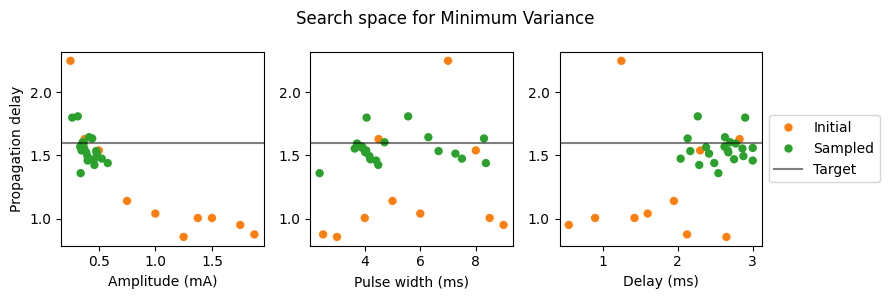

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_min_target['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_min_target[col], df_min_target['delay'], c=colors, edgecolors='none')
    ax[e].axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, label='Target')

]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Minimum Variance")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

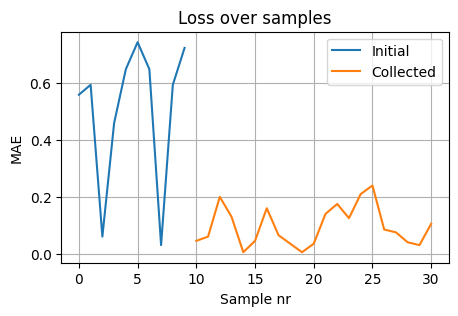

In [31]:
fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_min_target.loc[df_min_target['sample_type']=='Initial']
sub_df_1 = df_min_target.loc[~(df_min_target['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['Loss (MAE)'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_min_target)), sub_df_1['Loss (MAE)'], label='Collected')
ax.set_title("Loss over samples")
ax.set_xlabel("Sample nr")
ax.set_ylabel("MAE")
ax.grid()
ax.legend()

Text(0.5, 0.98, 'Distribution of APs')

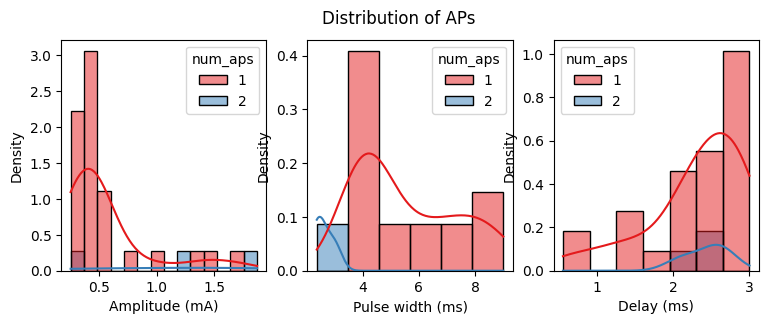

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(9,3))
for e, col in enumerate(col_names):
    sns.histplot(data=df_min_target, x=col, hue='num_aps',
                 kde=True,
                 #element='step',
                 stat='density',
                 common_norm=True,
                 palette='Set1',
                 ax=ax[e])

    ax[e].set_xlabel(col)
fig.suptitle("Distribution of APs")

## Optimization with constraints

Assume that, hypothetically, we would like to guarantee that only one AP is activated. Say that experiments with no APs are not informative, and that with 2 APs can damage the nerve. This can be approached in multiple ways, here we opt for Feasibility region and focus on optimizing a threshold (as in the last example) while preventing triggering 0, 2 or more than 2 APs.
We extend the first scenario: we want to minimize global uncertainty (Notice that we could also reproduce scenario 2)


In [33]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [34]:
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
obs_label[obs_label==np.inf] = 6
obs_label = np.abs(obs_label-target_delay)

constraint = np.array([obs['num_aps'] for obs in observations])==1
constraint = constraint.astype(int).reshape(-1,1)

init_dataset_objective = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                                 observations=tf.cast(obs_label, tf.float64))

init_dataset_constraint = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                                 observations=tf.cast(constraint, tf.float64))

init_dataset = {
    "OBJECTIVE" : init_dataset_objective,
    "CONSTRAINT" : init_dataset_constraint
}


In [35]:
# Build model
class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def __init__(self, thr: float|None=None):
        self.thr = thr
    def prepare_acquisition_function(self, model, dataset='CONSTRAINT'):
        def acquisition(at):
            mean, var = model.predict_y(tf.squeeze(at, -2))
            sigma = tf.sqrt(var)
            z = -mean/sigma
            pov = 0.5 * (1.0 + tf.math.erf(z / tf.sqrt(tf.constant(2.0, dtype=z.dtype))))
            return pov
        
        return acquisition
    
model_config = {
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'kernel_variance': None
}
problem_type = 'regression'
objective_model = online_learning.build_model(init_dataset['OBJECTIVE'], search_space, model_config,
                                              problem_type=problem_type)

# Classification is True for the Contrained model
model_config = {
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': False, # The constraint is noiselesss as the CAP occurs regardless of the noise estimate,
    'kernel_variance': None
}
problem_type = 'classification'
constraint_model = online_learning.build_model(init_dataset["CONSTRAINT"], search_space, model_config,
                                               problem_type=problem_type)

online_models = {"OBJECTIVE": objective_model,
                 "CONSTRAINT": constraint_model
                 }

    
# Set up acquisition function and rule
acq0 = AugmentedExpectedImprovement()
acq1 = ExpectedFeasibility(threshold=0.5, delta=1)
acq1 = ProbabilityOfValidity()
#acq1 = BayesianActiveLearningByDisagreement()

combined_acquisition = Product(acq0.using("OBJECTIVE"), acq1.using("CONSTRAINT"))
rule = EfficientGlobalOptimization(combined_acquisition, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell_constrained = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_models,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [36]:
# Optimization loop as for a next point to query

iter = 0
while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell_constrained.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell_constrained returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = MEAS_POSITION, 
                                            e_pos = STIM_DISTANCE,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False,
                                            noise_level=NOISE_LEVEL)
            
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    
    obs_label[obs_label == np.inf] = 6    
    obs_label = np.abs(obs_label-target_delay)

    constraint = np.array([obs['num_aps'] for obs in observations_new]) == 1
    constraint = constraint.astype(int).reshape(-1,1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = {"OBJECTIVE":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                                         observations=tf.cast(obs_label, tf.float64)),
                     "CONSTRAINT":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                                          observations=tf.cast(constraint, tf.float64))
    }
    
    # Update the optimizer with new data
    ask_tell_constrained.tell(tagged_output)
    iter += 1

# Save results
#ask_tell_constrained.save()

Config: Amp. 0.41 mA Freq. 6.36 KHz,  PW 2.64 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 205.46it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.5713658888016449, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 324, 'component_end_time': 530, 'upward_line_coords': ((324, 65), (443, 1)), 'downward_line_coords': ((324, 70), (530, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 6, 'component_start_time': 369, 'component_end_time': 382, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 405, 'component_end_time': 411, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 438, 'component_end_time': 441, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 203.22it/s]


{'delay': 1.4399999999999697, 'num_aps': 1, 'delay_noised': 1.363132480499883, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 285, 'component_end_time': 490, 'upward_line_coords': ((285, 65), (404, 1)), 'downward_line_coords': ((285, 70), (490, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 3, 'component_start_time': 441, 'component_end_time': 447, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 497, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.40 mA Freq. 5.57 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.91it/s]


{'delay': 1.614999999999966, 'num_aps': 1, 'delay_noised': 1.7689592308468791, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 319, 'component_end_time': 525, 'upward_line_coords': ((319, 66), (438, 1)), 'downward_line_coords': ((319, 69), (525, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 5, 'component_start_time': 372, 'component_end_time': 385, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 414, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 451, 'component_end_time': 454, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.62it/s]


{'delay': 1.4149999999999703, 'num_aps': 1, 'delay_noised': 1.572691715900412, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 279, 'component_end_time': 485, 'upward_line_coords': ((279, 66), (399, 1)), 'downward_line_coords': ((279, 69), (485, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 6, 'component_start_time': 354, 'component_end_time': 362, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 385, 'component_end_time': 391, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 415, 'component_end_time': 421, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.57it/s]


{'delay': 1.5099999999999683, 'num_aps': 1, 'delay_noised': 1.3498351540811293, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 295, 'component_end_time': 504, 'upward_line_coords': ((295, 67), (417, 1)), 'downward_line_coords': ((295, 68), (504, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 5, 'component_start_time': 360, 'component_end_time': 372, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 5, 'component_start_time': 404, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 443, 'component_end_time': 450, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.27it/s]


{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.5373609388861806, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 319, 'component_end_time': 523, 'upward_line_coords': ((319, 64), (436, 1)), 'downward_line_coords': ((319, 71), (523, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 381, 'component_end_time': 389, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 410, 'component_end_time': 413, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 437, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 218.53it/s]


{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.7428019040372749, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 318, 'component_end_time': 523, 'upward_line_coords': ((318, 65), (436, 1)), 'downward_line_coords': ((318, 70), (523, 202)), 'y_span_at_start': 6, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 2, 'component_start_time': 402, 'component_end_time': 402, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.57 mA Freq. 8.97 KHz,  PW 2.49 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 231.13it/s]


{'delay': 1.4449999999999696, 'num_aps': 1, 'delay_noised': 1.5557109306709171, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 287, 'component_end_time': 491, 'upward_line_coords': ((287, 64), (404, 1)), 'downward_line_coords': ((287, 71), (491, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 9, 'component_start_time': 336, 'component_end_time': 345, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 360, 'component_end_time': 366, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 384, 'component_end_time': 388, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.73it/s]


{'delay': 1.8399999999999612, 'num_aps': 1, 'delay_noised': 1.8705354462116337, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 365, 'component_end_time': 570, 'upward_line_coords': ((365, 65), (483, 1)), 'downward_line_coords': ((365, 70), (570, 202)), 'y_span_at_start': 4, 'min_y_at_start': 65, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 2, 'component_start_time': 437, 'component_end_time': 443, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.55 mA Freq. 8.17 KHz,  PW 2.54 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.24it/s]


{'delay': 1.4949999999999686, 'num_aps': 1, 'delay_noised': 1.5794294589987123, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 291, 'component_end_time': 501, 'upward_line_coords': ((291, 67), (414, 1)), 'downward_line_coords': ((291, 67), (501, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 7, 'component_start_time': 361, 'component_end_time': 368, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 387, 'component_end_time': 391, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 412, 'component_end_time': 416, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.98it/s]


{'delay': 1.4599999999999693, 'num_aps': 1, 'delay_noised': 1.6136752194696729, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 289, 'component_end_time': 494, 'upward_line_coords': ((289, 64), (407, 1)), 'downward_line_coords': ((289, 70), (494, 202)), 'y_span_at_start': 5, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 10, 'component_start_time': 336, 'component_end_time': 344, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 3, 'total_of_features': 10, 'component_start_time': 358, 'component_end_time': 363, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 10, 'component_start_time': 379, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.73it/s]


{'delay': 1.3999999999999706, 'num_aps': 1, 'delay_noised': 1.3344832271593798, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 279, 'component_end_time': 483, 'upward_line_coords': ((279, 63), (396, 1)), 'downward_line_coords': ((279, 71), (483, 202)), 'y_span_at_start': 9, 'min_y_at_start': 63, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 9, 'component_start_time': 328, 'component_end_time': 337, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 9, 'component_start_time': 354, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 9, 'component_start_time': 378, 'component_end_time': 383, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 225.96it/s]


{'delay': 1.519999999999968, 'num_aps': 1, 'delay_noised': 1.495292099951599, 'ap_lines': [{'label': 1, 'total_of_features': 9, 'component_start_time': 296, 'component_end_time': 506, 'upward_line_coords': ((296, 67), (419, 1)), 'downward_line_coords': ((296, 67), (506, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 9, 'component_start_time': 352, 'component_end_time': 360, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 9, 'component_start_time': 373, 'component_end_time': 379, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 9, 'component_start_time': 394, 'component_end_time': 398, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 230.34it/s]


{'delay': 0.864999999999982, 'num_aps': 2, 'delay_noised': 1.2006829241526518, 'ap_lines': [{'label': 1, 'total_of_features': 10, 'component_start_time': 160, 'component_end_time': 375, 'upward_line_coords': ((160, 67), (288, 1)), 'downward_line_coords': ((160, 68), (375, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 10, 'component_start_time': 214, 'component_end_time': 247, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 10, 'component_start_time': 294, 'component_end_time': 322, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 10, 'component_start_time': 367, 'component_end_time': 397, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 6

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 229.67it/s]


{'delay': 0.8549999999999822, 'num_aps': 2, 'delay_noised': 0.8600918821515086, 'ap_lines': [{'label': 1, 'total_of_features': 12, 'component_start_time': 158, 'component_end_time': 373, 'upward_line_coords': ((158, 67), (286, 1)), 'downward_line_coords': ((158, 68), (373, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 6, 'total_of_features': 12, 'component_start_time': 210, 'component_end_time': 242, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 7, 'total_of_features': 12, 'component_start_time': 287, 'component_end_time': 315, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 8, 'total_of_features': 12, 'component_start_time': 358, 'component_end_time': 387, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.23it/s]


{'delay': 0.8799999999999817, 'num_aps': 2, 'delay_noised': 0.8733604963753752, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 163, 'component_end_time': 379, 'upward_line_coords': ((163, 67), (292, 1)), 'downward_line_coords': ((163, 68), (379, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 223, 'component_end_time': 257, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 7, 'component_start_time': 308, 'component_end_time': 338, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 385, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.28it/s]


{'delay': 0.909999999999981, 'num_aps': 2, 'delay_noised': 0.7170732064603381, 'ap_lines': [{'label': 1, 'total_of_features': 7, 'component_start_time': 173, 'component_end_time': 384, 'upward_line_coords': ((173, 67), (297, 1)), 'downward_line_coords': ((173, 68), (384, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 7, 'component_start_time': 222, 'component_end_time': 255, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 7, 'component_start_time': 311, 'component_end_time': 337, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 7, 'component_start_time': 388, 'component_end_time': 418, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.60it/s]


{'delay': 1.3599999999999715, 'num_aps': 2, 'delay_noised': 1.4263027218171673, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 261, 'component_end_time': 474, 'upward_line_coords': ((261, 67), (387, 1)), 'downward_line_coords': ((261, 67), (474, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 326, 'component_end_time': 350, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 421, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 5, 'component_start_time': 635, 'component_end_time': 725, 'upward_line_coords': ((635, 42), (725, 1)), 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 42, 'max_

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 226.83it/s]


{'delay': 1.564999999999967, 'num_aps': 1, 'delay_noised': 1.4559385093000585, 'ap_lines': [{'label': 1, 'total_of_features': 2, 'component_start_time': 303, 'component_end_time': 516, 'upward_line_coords': ((303, 67), (429, 1)), 'downward_line_coords': ((303, 68), (516, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 2, 'component_start_time': 437, 'component_end_time': 445, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.58 mA Freq. 2.06 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 193.96it/s]


{'delay': 1.0149999999999788, 'num_aps': 2, 'delay_noised': 1.116743866385637, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 197, 'component_end_time': 405, 'upward_line_coords': ((197, 66), (318, 1)), 'downward_line_coords': ((197, 68), (405, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 5, 'total_of_features': 6, 'component_start_time': 252, 'component_end_time': 283, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 359, 'component_end_time': 386, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 450, 'component_end_time': 486, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 210.11it/s]


{'delay': 1.0299999999999785, 'num_aps': 2, 'delay_noised': 1.155311159401567, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 206, 'component_end_time': 409, 'upward_line_coords': ((206, 63), (322, 1)), 'downward_line_coords': ((206, 71), (409, 202)), 'y_span_at_start': 7, 'min_y_at_start': 63, 'max_y_at_start': 71}, {'label': 5, 'total_of_features': 6, 'component_start_time': 337, 'component_end_time': 359, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 6, 'component_start_time': 423, 'component_end_time': 453, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 520, 'component_end_time': 532, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

In [37]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df_with_constraints = pd.DataFrame(all_qp_array, columns=col_names)
df_with_constraints['sample_type'] = all_sample_types_array
df_with_constraints = pd.concat([df_with_constraints, df_all_observations],axis=1)
df_with_constraints['Real Loss (MAE)'] = np.abs(df_with_constraints['delay_noised'] - target_delay)
df_with_constraints['Loss (MAE)'] = np.abs(df_with_constraints['delay'] - target_delay)


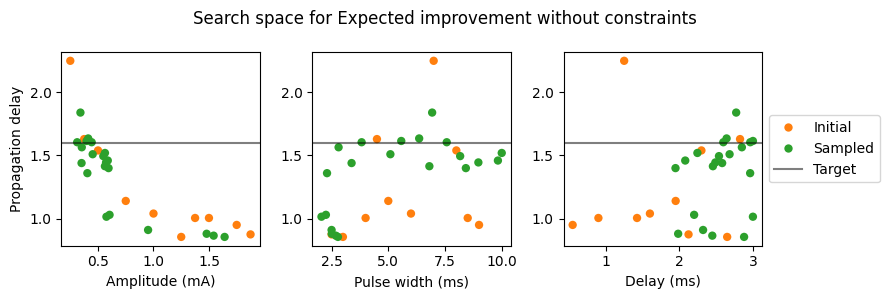

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_with_constraints['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_with_constraints[col], df_with_constraints['delay'], c=colors, edgecolors='none')
    ax[e].axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, label='Target')

]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Expected improvement without constraints")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

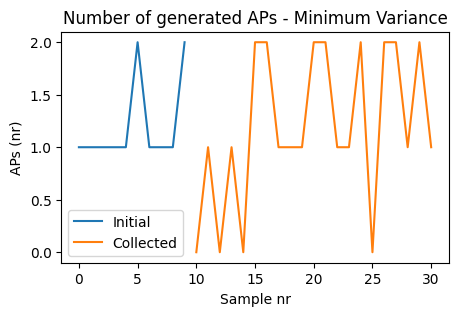

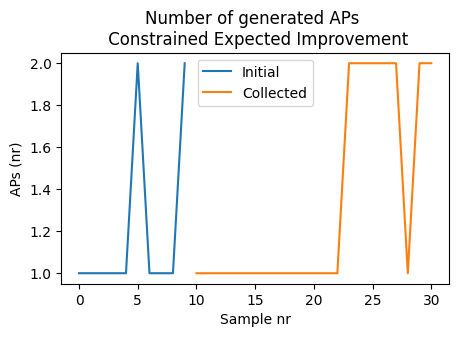

In [39]:
fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_min_variance.loc[df_min_variance['sample_type']=='Initial']
sub_df_1 = df_min_variance.loc[~(df_min_variance['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['num_aps'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_min_variance)), sub_df_1['num_aps'], label='Collected')
ax.set_title("Number of generated APs - Minimum Variance")
ax.set_xlabel("Sample nr")
ax.set_ylabel("APs (nr)")
ax.legend()


fig, ax = plt.subplots(figsize=(5,3))
sub_df_0 = df_with_constraints.loc[df_with_constraints['sample_type']=='Initial']
sub_df_1 = df_with_constraints.loc[~(df_with_constraints['sample_type']=='Initial')]
ax.plot(np.arange(len(sub_df_0)), sub_df_0['num_aps'], label='Initial')
ax.plot(np.arange(len(sub_df_0), len(df_with_constraints)), sub_df_1['num_aps'], label='Collected')
ax.set_title("Number of generated APs \n Constrained Expected Improvement")
ax.set_xlabel("Sample nr")
ax.set_ylabel("APs (nr)")
ax.legend()


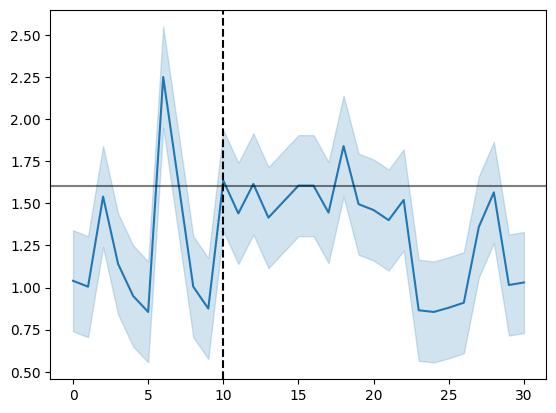

In [40]:
#df_with_constraints['delay'].plot()
plt.plot(df_with_constraints['delay'], color='C0')
plt.axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
plt.fill_between(np.arange(len(df_with_constraints)), 
                 df_with_constraints['delay']- NOISE_LEVEL*3,
                    df_with_constraints['delay']+ NOISE_LEVEL*3, color='C0', 
                    alpha=0.2, label='Noise range')
plt.axvline(init_samples, color = 'k', ls='--', label='Start optimization')
plt.show()

Text(0.5, 1.0, 'Loss over samples - Constrained Expected Improvement')

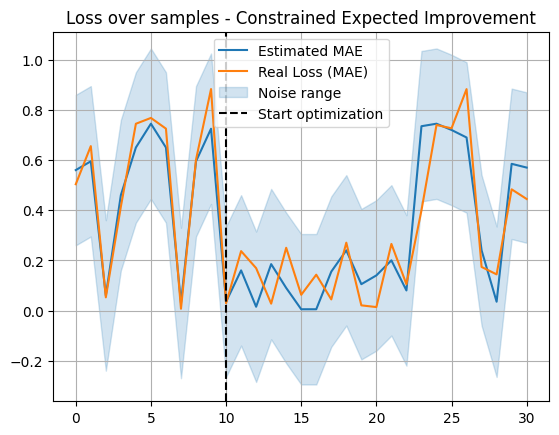

In [41]:
df_with_constraints['Loss (MAE)'].plot(label='Estimated MAE', color='C0')
df_with_constraints['Real Loss (MAE)'].plot(label='Real Loss (MAE)', color='C1')
plt.fill_between(np.arange(len(df_with_constraints)),
                 df_with_constraints['Loss (MAE)']- NOISE_LEVEL*3,
                 np.clip(df_with_constraints['Loss (MAE)']+ NOISE_LEVEL*3, 0, None), color='C0',
                 alpha=0.2, label='Noise range')

plt.axvline(init_samples, color = 'k', ls='--', label='Start optimization')
plt.legend()
plt.grid()
plt.title("Loss over samples - Constrained Expected Improvement")

## Additional

## Using the learned model (with constraints) to find an optimal solution usign gradient minimzers

In [42]:
# 1. Get the final, trained models from the optimizer
objective_model = ask_tell_constrained.models['OBJECTIVE']
constraint_model = ask_tell_constrained.models['CONSTRAINT']

# 2. Define a function that returns the model's predicted objective
#    We will use scipy.optimize to minimize this function.
def prediction_objective_fn(x):
    query_point = tf.cast(np.atleast_2d(x), dtype=tf.float64)
    
    # Get predictions from both models
    # We want the *mean* of the prediction
    predicted_objective_mean, _ = objective_model.predict(query_point)
    predicted_constraint_mean, _ = constraint_model.predict(query_point)
    
    # Penalize the objective if the constraint is not likely to be met.
    # If predicted_constraint_mean is close to 1, the penalty is ~0.
    # If it's close to 0, the penalty is large.
    # This turns it into a single objective minimization problem.
    constraint_penalty = 100 * (1.0 - predicted_constraint_mean[0, 0])**2
    
    # Return the value to be minimized
    return predicted_objective_mean[0, 0] + constraint_penalty

# Alternative to optimize toward LCB
def lcb_objective_fn(x, kappa=1.96): # kappa=1.96 corresponds to the 95% confidence interval
    # Reshape for the model and cast to the correct dtype
    query_point = tf.cast(np.atleast_2d(x), dtype=tf.float64)
    
    # Get predictions (mean and variance) from the objective model
    predicted_objective_mean, predicted_objective_var = objective_model.predict(query_point)
    predicted_objective_std = tf.sqrt(predicted_objective_var) # Standard deviation = sqrt(variance)

    # Get prediction from the constraint model
    predicted_constraint_mean, _ = constraint_model.predict(query_point)
    
    # Calculate the Lower Confidence Bound (LCB)
    lcb_value = predicted_objective_mean[0, 0] - kappa * predicted_objective_std[0, 0]
    
    # Add the same constraint penalty as before
    # We want points that are confidently good AND satisfy the constraint
    constraint_penalty = 100 * (1.0 - predicted_constraint_mean[0, 0])**2
    
    # Return the value to be minimized
    return lcb_value + constraint_penalty
# 3. Run the optimization
bounds = [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
best_params = df_with_constraints.loc[df_with_constraints['Loss (MAE)'].idxmin(), col_names].values

# Use the best observed point as a smart starting guess
best_observed_minmax = scaler.transform(best_params.reshape(1, -1))
initial_guess = best_observed_minmax.flatten()

# Run scipy's minimizer
result = minimize(
    lcb_objective_fn, # lcb_objective_fn or prediction_objective_fn
    x0=initial_guess,
    bounds=bounds,
    method='L-BFGS-B'
)

# 4. Extract and inverse-transform the predicted best parameters
predicted_best_params_minmax = result.x
predicted_best_params = scaler.inverse_transform(predicted_best_params_minmax.reshape(1, -1)).flatten()


In [43]:
pd.DataFrame(scaler.transform(df_with_constraints[col_names])).describe()

,0,1,2
count,31.000000,31.000000,31.000000
mean,-0.215749,-0.142480,0.498176
std,0.496787,0.653092,0.442420
min,-0.750000,-0.986217,-0.750000
25%,-0.592338,-0.801289,0.308615
50%,-0.427721,-0.226864,0.611581
75%,0.125000,0.447016,0.805464
max,0.875000,1.000000,1.000000


In [44]:
best_params, initial_guess

(array([0.44285089668944433, 7.576125294936212, 2.5976234776386327],
       dtype=object),
 array([-0.5571491033105557, 0.3940313237340529, 0.7125881983133089],
       dtype=object))

In [45]:
print("\n--- Model-Predicted Optimal Result ---")
print(f"Scipy optimization successful: {result.success}")
print(f"Predicted minimum MAE: {result.fun:.4f}")
print("\nPredicted Best Parameters:")
print(f"  - Stim Amp:  {predicted_best_params[0]:.4f}")
print(f"  - Stim Freq: {predicted_best_params[1]:.4f}")
print(f"  - Stim PW:   {predicted_best_params[2]:.4f}")


--- Model-Predicted Optimal Result ---
Scipy optimization successful: True
Predicted minimum MAE: 60.8677

Predicted Best Parameters:
  - Stim Amp:  0.0000
  - Stim Freq: 10.0000
  - Stim PW:   3.0000


In [46]:
print(initial_guess)
print(best_params)

[-0.5571491033105557 0.3940313237340529 0.7125881983133089]
[0.44285089668944433 7.576125294936212 2.5976234776386327]


Config: Amp. 0.44 mA Freq. 7.58 KHz,  PW 2.60 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 211.42it/s]


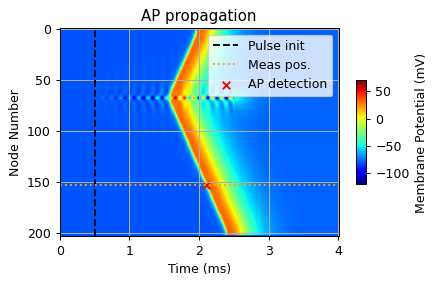

{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.591110918198435, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 319, 'component_end_time': 523, 'upward_line_coords': ((319, 64), (436, 1)), 'downward_line_coords': ((319, 71), (523, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 381, 'component_end_time': 389, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 410, 'component_end_time': 413, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 437, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, 

In [47]:
sim_results_initial_guess = sinusoid_delay_objective(mrg,
                                        stim_amp = [best_params[0]],
                                        stim_freq = [best_params[1]],
                                        stim_pw = [best_params[2]],
                                        stim_delay = stim_delays,
                                        meas_position = MEAS_POSITION, 
                                        e_pos = STIM_DISTANCE,
                                        abs_diff = False,
                                        sim_time = 4,
                                        plot_results = True,
                                        noise_level=NOISE_LEVEL)
            

Config: Amp. 0.00 mA Freq. 10.00 KHz,  PW 3.00 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 207.07it/s]


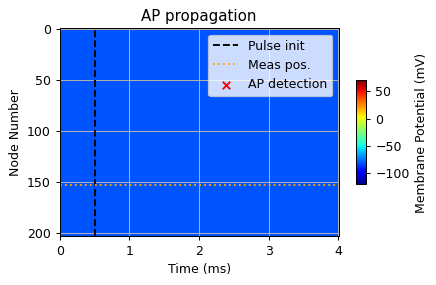

{'delay': inf, 'num_aps': 0, 'delay_noised': inf, 'ap_lines': []}


In [48]:
sim_results_optimized = sinusoid_delay_objective(mrg,
                                        stim_amp = [predicted_best_params[0]],
                                        stim_freq = [predicted_best_params[1]],
                                        stim_pw = [predicted_best_params[2]],
                                        stim_delay = stim_delays,
                                        meas_position = MEAS_POSITION, 
                                        e_pos = STIM_DISTANCE,
                                        abs_diff = False,
                                        sim_time = 4,
                                        plot_results = True,
                                        noise_level=NOISE_LEVEL)
            

In [49]:
print(sim_results_initial_guess)
print(sim_results_optimized)
print(target_delay)

[{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.591110918198435, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 319, 'component_end_time': 523, 'upward_line_coords': ((319, 64), (436, 1)), 'downward_line_coords': ((319, 71), (523, 202)), 'y_span_at_start': 6, 'min_y_at_start': 64, 'max_y_at_start': 71}, {'label': 2, 'total_of_features': 6, 'component_start_time': 381, 'component_end_time': 389, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 410, 'component_end_time': 413, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 437, 'component_end_time': 440, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

In [50]:
online_models['OBJECTIVE']._model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,(),float64,0.5731101636309663
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.05285908334426314
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(3,)",float64,[0.12782478 0.66094318 0.29352572]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0006278546042558e-07
GPR.data[0],ResourceVariable,,,False,"(None, 3)",float64,"[[0., 0., 0...."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0.50361858...


In [51]:
online_models['CONSTRAINT']._model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,(),float64,1.35245
VGP.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,1.70509
VGP.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(3,)",float64,[0.84763637 0.29724912 0.80079424]
VGP.data[0],ResourceVariable,,,False,"(None, 3)",float64,"[[0., 0., 0...."
VGP.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGP.num_data,Parameter,Identity,,False,(),int32,31
VGP.q_mu,Parameter,Identity,,True,"(None, 1)",float64,[[0.6634975...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, None, None)",float64,"[[[8.33626676e-01, 0.00000000e+00, 0.00000000e+00..."


## Optimization focused on exploitation with greedy search

In [52]:
# If Noise is higher than 0 we assume we are dealing with noisy simulations and select the noised injected sample
if NOISE_LEVEL>0:
    obs_label = np.array([o['delay_noised'] for o in observations]).reshape(-1,1)
else:
    obs_label = np.array([o['delay'] for o in observations]).reshape(-1,1)

obs_label[obs_label == np.inf] = 6
obs_label = np.abs(obs_label-target_delay)

real_label = np.array([o['delay'] for o in observations]).reshape(-1,1)
# We replace np.inf values with a fixed and relatively large value 
#  (outside of the simulation range)
    
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))


In [53]:
# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp_orig_scale)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp_orig_scale))

In [54]:
# Build model
from online_neuro.custom_acquisitions import ExpectedImprovementXsi
model_config = {
    'variational': False,
    'sparse': False,
    'trainable_likelihood': True,
    'likelihood_variance':1e-5,
    'kernel_variance': None,
}
problem_type = 'regression'
online_model = online_learning.build_model(init_dataset, 
                                           search_space,
                                           model_config,
                                           problem_type=problem_type)

# Set up acquisition function and rule
acq = ExpectedImprovementXsi(xsi=-0.2)
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell_greedy = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [55]:
# Optimization loop as for a next point to query

iter = 0
while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell_greedy.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell_constrained returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)
    if qp_new.ndim==1:
        qp_new = qp_new.reshape(-1, 1)
    stim_delays = len(qp_new)*[STIM_DELAY]

    # Run the simulation and get observations
    observations_new = sinusoid_delay_objective(mrg,
                                            stim_amp = qp_new[:, 0],
                                            stim_freq = qp_new[:, 1],
                                            stim_pw = qp_new[:, 2],
                                            stim_delay = stim_delays,
                                            meas_position = MEAS_POSITION, 
                                            e_pos = STIM_DISTANCE,
                                            abs_diff = False,
                                            sim_time = 4,
                                            plot_results = False,
                                            noise_level=NOISE_LEVEL)
            
    if NOISE_LEVEL>0:
        obs_label = np.array([o['delay_noised'] for o in observations_new]).reshape(-1,1)
    else:
        obs_label = np.array([o['delay'] for o in observations_new]).reshape(-1,1)
    
    obs_label[obs_label == np.inf] = 6    
    obs_label = np.abs(obs_label-target_delay)

    constraint = np.array([obs['num_aps'] for obs in observations_new]) == 1
    constraint = constraint.astype(int).reshape(-1,1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = {"OBJECTIVE":Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                                         observations=tf.cast(obs_label, tf.float64))
    }
    
    # Update the optimizer with new data
    ask_tell_greedy.tell(tagged_output)
    iter += 1

# Save results
#ask_tell_greedy.save()

Config: Amp. 0.40 mA Freq. 5.73 KHz,  PW 2.68 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 213.90it/s]


{'delay': 1.5899999999999666, 'num_aps': 1, 'delay_noised': 1.4796614192794753, 'ap_lines': [{'label': 1, 'total_of_features': 5, 'component_start_time': 315, 'component_end_time': 521, 'upward_line_coords': ((315, 65), (434, 1)), 'downward_line_coords': ((315, 69), (521, 202)), 'y_span_at_start': 3, 'min_y_at_start': 65, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 5, 'component_start_time': 364, 'component_end_time': 378, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 5, 'component_start_time': 405, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 5, 'component_start_time': 441, 'component_end_time': 444, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67},

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 221.31it/s]


{'delay': 1.5749999999999669, 'num_aps': 1, 'delay_noised': 1.5634906324802258, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 314, 'component_end_time': 517, 'upward_line_coords': ((314, 66), (431, 1)), 'downward_line_coords': ((314, 68), (517, 202)), 'y_span_at_start': 3, 'min_y_at_start': 66, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 3, 'component_start_time': 411, 'component_end_time': 412, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 457, 'component_end_time': 461, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.39 mA Freq. 4.82 KHz,  PW 2.80 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 216.82it/s]


{'delay': 1.5749999999999669, 'num_aps': 1, 'delay_noised': 1.4636751608535803, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 311, 'component_end_time': 518, 'upward_line_coords': ((311, 66), (431, 1)), 'downward_line_coords': ((311, 69), (518, 202)), 'y_span_at_start': 4, 'min_y_at_start': 66, 'max_y_at_start': 69}, {'label': 2, 'total_of_features': 4, 'component_start_time': 375, 'component_end_time': 387, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 423, 'component_end_time': 424, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 464, 'component_end_time': 469, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.63it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.6988834560079735, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 529, 'upward_line_coords': ((319, 67), (442, 1)), 'downward_line_coords': ((319, 68), (529, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 397, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 446, 'component_end_time': 449, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 489, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.34it/s]


{'delay': 1.519999999999968, 'num_aps': 1, 'delay_noised': 1.427127989518689, 'ap_lines': [{'label': 1, 'total_of_features': 3, 'component_start_time': 302, 'component_end_time': 507, 'upward_line_coords': ((302, 64), (420, 1)), 'downward_line_coords': ((302, 70), (507, 202)), 'y_span_at_start': 7, 'min_y_at_start': 64, 'max_y_at_start': 70}, {'label': 2, 'total_of_features': 3, 'component_start_time': 375, 'component_end_time': 384, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 3, 'component_start_time': 476, 'component_end_time': 482, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}
Config: Amp. 0.49 mA Freq. 7.56 KHz,  PW 2.41 ms, Delay 0.50 ms


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.28it/s]


{'delay': 1.569999999999967, 'num_aps': 1, 'delay_noised': 1.5117322145046999, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 306, 'component_end_time': 516, 'upward_line_coords': ((306, 67), (430, 1)), 'downward_line_coords': ((306, 67), (516, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 6, 'component_start_time': 382, 'component_end_time': 389, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 410, 'component_end_time': 414, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 6, 'component_start_time': 437, 'component_end_time': 441, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, 

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 223.16it/s]


{'delay': 1.569999999999967, 'num_aps': 1, 'delay_noised': 1.820795231424974, 'ap_lines': [{'label': 1, 'total_of_features': 6, 'component_start_time': 307, 'component_end_time': 517, 'upward_line_coords': ((307, 67), (430, 1)), 'downward_line_coords': ((307, 68), (517, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 6, 'component_start_time': 380, 'component_end_time': 387, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 6, 'component_start_time': 408, 'component_end_time': 412, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 4, 'total_of_features': 6, 'component_start_time': 435, 'component_end_time': 439, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 206.79it/s]


{'delay': 1.5749999999999669, 'num_aps': 1, 'delay_noised': 1.7956810209051832, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 310, 'component_end_time': 517, 'upward_line_coords': ((310, 67), (430, 1)), 'downward_line_coords': ((310, 68), (517, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 374, 'component_end_time': 386, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 422, 'component_end_time': 423, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 462, 'component_end_time': 467, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 220.53it/s]


{'delay': 1.5949999999999664, 'num_aps': 1, 'delay_noised': 1.421822120276915, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 314, 'component_end_time': 522, 'upward_line_coords': ((314, 67), (435, 1)), 'downward_line_coords': ((314, 68), (522, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 382, 'component_end_time': 393, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 431, 'component_end_time': 432, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 472, 'component_end_time': 477, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.20it/s]


{'delay': 1.6049999999999662, 'num_aps': 1, 'delay_noised': 1.5183582082676839, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 315, 'component_end_time': 523, 'upward_line_coords': ((315, 67), (436, 1)), 'downward_line_coords': ((315, 68), (523, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 386, 'component_end_time': 396, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 434, 'component_end_time': 436, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 476, 'component_end_time': 482, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.37it/s]


{'delay': 1.614999999999966, 'num_aps': 1, 'delay_noised': 1.4548629447578771, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 316, 'component_end_time': 525, 'upward_line_coords': ((316, 67), (438, 1)), 'downward_line_coords': ((316, 68), (525, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 389, 'component_end_time': 399, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 3, 'total_of_features': 4, 'component_start_time': 437, 'component_end_time': 439, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 479, 'component_end_time': 486, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.97it/s]


{'delay': 1.619999999999966, 'num_aps': 1, 'delay_noised': 1.636158246359733, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 316, 'component_end_time': 526, 'upward_line_coords': ((316, 67), (439, 1)), 'downward_line_coords': ((316, 67), (526, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 390, 'component_end_time': 400, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 439, 'component_end_time': 442, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 481, 'component_end_time': 488, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}


3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 222.37it/s]


{'delay': 1.6249999999999658, 'num_aps': 1, 'delay_noised': 1.5360202986164677, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 317, 'component_end_time': 527, 'upward_line_coords': ((317, 67), (440, 1)), 'downward_line_coords': ((317, 67), (527, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 393, 'component_end_time': 403, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 442, 'component_end_time': 445, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 485, 'component_end_time': 492, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.55it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.5835638712217046, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 318, 'component_end_time': 529, 'upward_line_coords': ((318, 67), (442, 1)), 'downward_line_coords': ((318, 67), (529, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 397, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 446, 'component_end_time': 449, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 489, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 224.53it/s]


{'delay': 1.6399999999999655, 'num_aps': 1, 'delay_noised': 1.5860645772886293, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 530, 'upward_line_coords': ((319, 67), (443, 1)), 'downward_line_coords': ((319, 68), (530, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 400, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 449, 'component_end_time': 453, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 493, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 197.67it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.5691222839521235, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 530, 'upward_line_coords': ((319, 67), (443, 1)), 'downward_line_coords': ((319, 68), (530, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 400, 'component_end_time': 408, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 448, 'component_end_time': 452, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 492, 'component_end_time': 499, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 217.57it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.4839338916775042, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 318, 'component_end_time': 529, 'upward_line_coords': ((318, 67), (442, 1)), 'downward_line_coords': ((318, 67), (529, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 397, 'component_end_time': 406, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 446, 'component_end_time': 449, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 489, 'component_end_time': 496, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 220.31it/s]


{'delay': 1.6349999999999656, 'num_aps': 1, 'delay_noised': 1.438561780268378, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 530, 'upward_line_coords': ((319, 67), (443, 1)), 'downward_line_coords': ((319, 68), (530, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 404, 'component_end_time': 411, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 452, 'component_end_time': 456, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 496, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:04<00:00, 165.97it/s]


{'delay': 1.6399999999999655, 'num_aps': 1, 'delay_noised': 1.7069456024584553, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 530, 'upward_line_coords': ((319, 67), (443, 1)), 'downward_line_coords': ((319, 68), (530, 202)), 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}, {'label': 2, 'total_of_features': 4, 'component_start_time': 400, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 449, 'component_end_time': 453, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 493, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 227.52it/s]


{'delay': 1.6399999999999655, 'num_aps': 1, 'delay_noised': 1.537779456363546, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 530, 'upward_line_coords': ((319, 67), (443, 1)), 'downward_line_coords': ((319, 67), (530, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 401, 'component_end_time': 409, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 449, 'component_end_time': 453, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 493, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}]}

3.5 ms: 100%|██████████| 800/800 [00:03<00:00, 219.98it/s]


{'delay': 1.6399999999999655, 'num_aps': 1, 'delay_noised': 1.636869864399203, 'ap_lines': [{'label': 1, 'total_of_features': 4, 'component_start_time': 319, 'component_end_time': 530, 'upward_line_coords': ((319, 67), (443, 1)), 'downward_line_coords': ((319, 67), (530, 202)), 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 2, 'total_of_features': 4, 'component_start_time': 402, 'component_end_time': 410, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 3, 'total_of_features': 4, 'component_start_time': 451, 'component_end_time': 455, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 1, 'min_y_at_start': 67, 'max_y_at_start': 67}, {'label': 4, 'total_of_features': 4, 'component_start_time': 495, 'component_end_time': 500, 'upward_line_coords': None, 'downward_line_coords': None, 'y_span_at_start': 2, 'min_y_at_start': 67, 'max_y_at_start': 68}]}

In [56]:
# Concatenate all data
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df_greedy = pd.DataFrame(all_qp_array, columns=col_names)
df_greedy['sample_type'] = all_sample_types_array
df_greedy = pd.concat([df_greedy, df_all_observations],axis=1)
df_greedy['Real Loss (MAE)'] = np.abs(df_greedy['delay_noised'] - target_delay)
df_greedy['Loss (MAE)'] = np.abs(df_greedy['delay'] - target_delay)


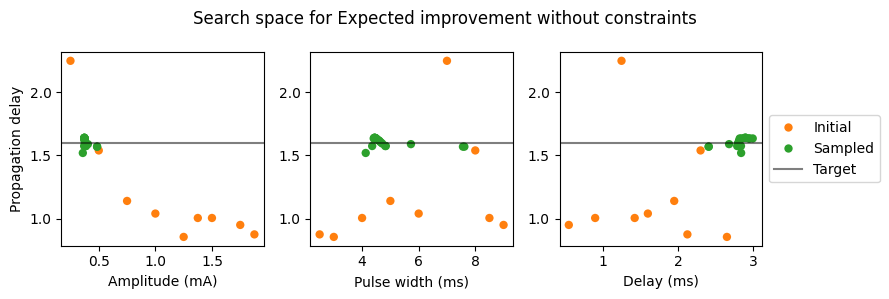

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
colors = [
    'C1' if t == 'Initial' else 'C2'
    for t in df_greedy['sample_type']
]

for e, col in enumerate(col_names):
    ax[e].scatter(df_greedy[col], df_greedy['delay'], c=colors, edgecolors='none')
    ax[e].axhline(target_delay, color='k', alpha=0.5, label='Target {target_delay:.2f}')
    ax[e].set_xlabel(col)

# Legend: no white line, placed outside
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Initial', 
           markerfacecolor='C1', markeredgecolor='none', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Sampled', 
           markerfacecolor='C2', markeredgecolor='none', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, label='Target')

]

# Place outside the last subplot
ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax[0].set_ylabel("Propagation delay")
fig.suptitle("Search space for Expected improvement without constraints")
fig.tight_layout()
#fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space to fit legend
plt.show()

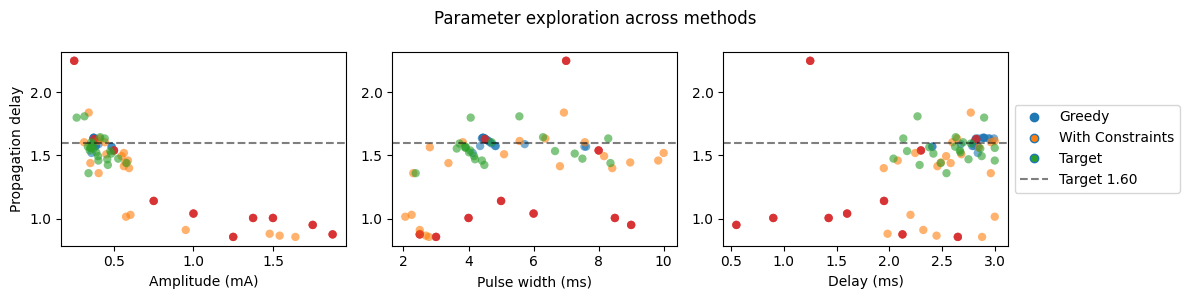

In [58]:
colors_map = {
    'Greedy': 'C0',
    'With Constraints': 'C1',
    'Target': 'C2'
}

dfs = {
    'Greedy': df_greedy,
    'With Constraints': df_with_constraints,
    'Target': df_min_target
}

fig, ax = plt.subplots(ncols=len(col_names), figsize=(4*len(col_names), 3))

for e, col in enumerate(col_names):
    for label, df in dfs.items():
        colors = [
            'C3' if t == 'Initial' else colors_map[label]
            for t in df['sample_type']
        ]
        ax[e].scatter(df[col], df['delay'], c=colors, edgecolors='none', alpha=0.6, label=label)
    ax[e].axhline(target_delay, color='k', alpha=0.5, linestyle='--')
    ax[e].set_xlabel(col)

ax[0].set_ylabel("Propagation delay")

# Build legend manually to avoid duplicate labels
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', label='Greedy', markerfacecolor='C0', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='With Constraints', markerfacecolor='C1', markersize=6),
    Line2D([0], [0], marker='o', linestyle='None', label='Target', markerfacecolor='C2', markersize=6),
    Line2D([0], [0], color='k', alpha=0.5, linestyle='--', label=f'Target {target_delay:.2f}')
]

ax[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Parameter exploration across methods")
fig.tight_layout()
plt.show()

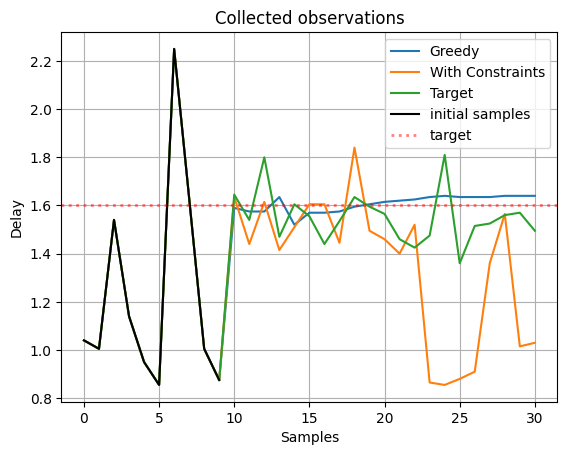

In [64]:
fig, ax = plt.subplots()

for k,v in dfs.items():
    plt.plot(v['delay'],label=k)
plt.plot(v['delay'].iloc[:init_samples], c='k', label='initial samples')
plt.axhline(target_delay, c= 'r', alpha=0.5, linestyle=':', linewidth=2, label='target')
plt.title("Collected observations")
plt.ylabel("Delay")
plt.grid()
plt.xlabel("Samples")
plt.legend()
plt.show()
